# Mini Project - 1

In [1]:
import json
import csv
import pandas as pd
import os
import numpy as np
import string

Converting json to csv of review file

In [ ]:
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('yelp_academic_dataset_review.json',encoding="utf-8") as f:    # encoding added
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
outfile.close()

In [2]:
df_reviews = pd.read_csv('review_stars.tsv', delimiter ="\t",encoding="utf-8")

In [ ]:
#json to csv of business file

outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'categories','review_count'])
with open('yelp_academic_dataset_business.json',encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['stars'], row['categories'],row['review_count']])
outfile.close()

In [3]:
df_business = pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8", nrows=10000)

In [4]:
# Grouping of reviews(Text) by BusinessId

review_agg = df_reviews.groupby('business_id')['text'].sum()     #grouping
df_review_agg = pd.DataFrame({'business_id': review_agg.index, 'all_reviews': review_agg.values}) #dataframe made

In [5]:
#Merge on review and business on BusinessID
df_review_business = pd.merge(df_review_agg, df_business, on='business_id')

In [6]:
df_review_business.shape

(10000, 5)

Normalizing review_count in range 0 to 1 

In [7]:
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low


In [8]:
encode_numeric_range(df_review_business,'review_count')

## TFIDF 

In [9]:
import sklearn.feature_extraction.text as sk_text
vectorizer = sk_text.TfidfVectorizer(stop_words='english',
                            max_features = 500,
                            min_df=1
                            #max_df=5
                            )

#min_df: ignore terms that have a document frequency < min_df.
#max_df: ignore terms that have a document frequency > max_df


matrix = vectorizer.fit_transform(df_review_business['all_reviews'])
print(type(matrix))               # Compressed Sparse Row matrix

tfidf_data = matrix.toarray()     #  convert it to numpy array
pd.set_option('display.max_colwidth',-1)
print(tfidf_data)
print(vectorizer.get_feature_names())

<class 'scipy.sparse.csr.csr_matrix'>
[[0.03794956 0.02593188 0.03092031 ... 0.         0.         0.        ]
 [0.         0.05308725 0.         ... 0.         0.         0.        ]
 [0.         0.         0.04390887 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.11546822 0.         0.        ]]
['00', '10', '15', '20', '30', '50', 'able', 'absolutely', 'actually', 'add', 'ago', 'amazing', 'appointment', 'area', 'arrived', 'ask', 'asked', 'ate', 'atmosphere', 'attentive', 'authentic', 'available', 'average', 'away', 'awesome', 'bacon', 'bad', 'bar', 'bbq', 'beautiful', 'beef', 'beer', 'believe', 'best', 'better', 'big', 'birthday', 'bit', 'bite', 'bought', 'bowl', 'bread', 'breakfast', 'bring', 'brought', 'brunch', 'burger', 'burgers', 'burrito', 'business', 'busy', 'buy', 'cafe', 'cake', 'called', 'came

In [10]:
tfidf_data.shape

(10000, 500)

In [11]:
#Converting review_count in Numpy Array
review_array=df_review_business['review_count'].values
review_array.shape

(10000,)

In [162]:
#Converting review_count array into vertical stack
vertical_review=np.vstack(review_array)
#Concatenating review_text tfidf array and review_count array
x = np.concatenate((tfidf_data, vertical_review), axis=1)
x.shape

(10000, 501)

In [163]:
y=df_review_business['stars']
y.shape

(10000,)

### Keeping first 5 data for future testing 

In [164]:
b_id = df_business['business_id'][0:5]
b_id
testx = x[0:5]
x=x[5:10000]
testy = y[0:5]
y=y[5:10000]

Function to plot confusion matrix

In [165]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Linear Regression

In [166]:
#Linear Regression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

XTrain, XTest, YTrain, YTest = train_test_split(x, y, test_size=0.2, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(XTrain, YTrain)
liReg_pred = regr.predict(XTest)

print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(YTest, liReg_pred))
print('Variance score: %.2f' % r2_score(YTest, liReg_pred))

Coefficients: 
 [-1.24545355e+00 -3.59317465e-01 -4.60622627e-01 -5.78865960e-01
 -5.58623620e-01 -1.70003914e-01  1.16398403e+00 -6.41631720e-02
 -3.73815259e-01  8.07880794e-02  3.25843653e-02  1.41566444e+00
 -2.91254863e-01  7.09847186e-02  3.51372293e-01  2.04182862e-01
 -3.37236000e-01  4.39322343e-01  2.00526042e-01 -1.07803618e-01
  8.49304610e-01  1.84588599e-01 -1.45905249e+00 -5.63127920e-01
  1.68703035e+00 -1.75600347e-01 -1.26066199e+00 -1.93002323e-01
  1.76864142e-01  6.60766756e-01  2.85065843e-01  1.58763464e-01
 -7.00775523e-01  1.36708753e+00 -4.72648427e-01  3.05699818e-01
 -8.56463804e-02  5.10189862e-01 -7.22665958e-02 -5.24655059e-01
  1.87857727e-01  1.06922863e-01  3.39949315e-01  6.21307035e-01
 -5.04225880e-02  5.12432285e-02 -9.42282571e-02  3.68346346e-01
 -8.53675234e-02 -3.08258640e-01  1.32009799e-01 -2.46114884e-01
  1.05239968e-02  1.23141654e-01 -5.32347265e-01  4.09099297e-02
  8.78198961e-03  4.12568914e-02  8.86198839e-02  5.34527068e-03
 -2.30107

In [167]:
predy=regr.predict(testx)
print("      Business id      | actual stars | predicted stars")
print("-----------------------|--------------|----------------")
for i in range(0,5):   
   print("%s |%10d    | %10d"
         %(b_id[i], testy[i], predy[i]))

      Business id      | actual stars | predicted stars
Apn5Q_b6Nz61Tq4XzPdf9A |         4    |          5
AjEbIBw6ZFfln7ePHha9PA |         3    |          2
O8S5hYJ1SMc8fA4QBtVujA |         4    |          3
bFzdJJ3wp3PZssNEsyU23g |         4    |          3
8USyCYqpScwiNEb58Bt6CA |         3    |          3


### Applying Label Encoding on stars for classification models

In [168]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

In [180]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
stars=encode_text_index(df_review_business,"stars")   # label encoding

In [181]:
finalx=x
y = df_review_business['stars'].values
testy = y[0:5]
finaly=y[5:10000]


In [182]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(finalx, finaly, test_size=0.2, random_state=42)

## Logistic Regression

Final accuracy: 0.3711855927963982
[[ 14   1  10  13   0   3   1   0   0]
 [  4   2   5  28   3   6   3   1   0]
 [  5   1   6  36  31  24   5   2   1]
 [  4   0   6  52  49  64  15   2   4]
 [  0   0   1  31  59 113  43   5   6]
 [  0   0   0  17  43 125 100  19  47]
 [  0   0   0   5  15  92 174  46  45]
 [  0   0   0   2   1  28 112  52  87]
 [  0   0   0   2   1  11  20  38 258]]
Plotting confusion matrix


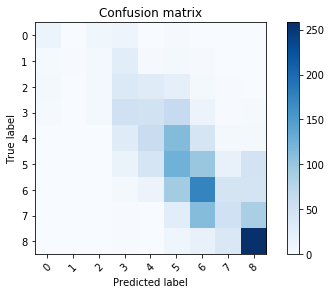

             precision    recall  f1-score   support

          0       0.52      0.33      0.41        42
          1       0.50      0.04      0.07        52
          2       0.21      0.05      0.09       111
          3       0.28      0.27      0.27       196
          4       0.29      0.23      0.26       258
          5       0.27      0.36      0.31       351
          6       0.37      0.46      0.41       377
          7       0.32      0.18      0.23       282
          8       0.58      0.78      0.66       330

avg / total       0.36      0.37      0.35      1999

      Business id      | actual stars | predicted stars
-----------------------|--------------|----------------
Apn5Q_b6Nz61Tq4XzPdf9A |         7    |          7
AjEbIBw6ZFfln7ePHha9PA |         4    |          5
O8S5hYJ1SMc8fA4QBtVujA |         7    |          6
bFzdJJ3wp3PZssNEsyU23g |         6    |          6
8USyCYqpScwiNEb58Bt6CA |         5    |          6


In [183]:
#Logistic Reg

# import the class
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_Train, Y_Train)

# predict the response for new observations
logreg_pred = logreg.predict(X_Test)

#accuracy
score = metrics.accuracy_score(Y_Test, logreg_pred)
print("Final accuracy: {}".format(score))

cm = metrics.confusion_matrix(Y_Test, logreg_pred)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, stars)
plt.show()

print(metrics.classification_report(Y_Test, logreg_pred))

predy=logreg.predict(testx)
print("      Business id      | actual stars | predicted stars")
print("-----------------------|--------------|----------------")
for i in range(0,5):   
   print("%s |%10d    | %10d"
         %(b_id[i], testy[i], predy[i]))

## Support Vector Machine

Final accuracy: 0.4307153576788394
[[ 14   4   8  13   0   2   1   0   0]
 [  5   3  12  25   1   5   1   0   0]
 [  6   2  12  58  19  13   0   0   1]
 [  7   2   8  78  54  41   4   2   0]
 [  1   0   7  44  76 102  24   2   2]
 [  0   0   1  21  44 172  72  16  25]
 [  0   0   0   6  14 103 179  53  22]
 [  0   0   0   0   0  30 105  85  62]
 [  0   0   0   2   1  13  23  49 242]]
Plotting confusion matrix


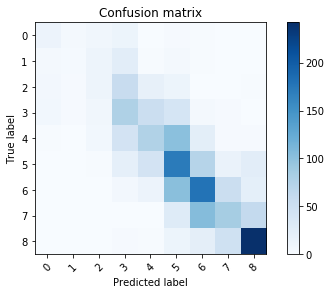

             precision    recall  f1-score   support

          0       0.42      0.33      0.37        42
          1       0.27      0.06      0.10        52
          2       0.25      0.11      0.15       111
          3       0.32      0.40      0.35       196
          4       0.36      0.29      0.33       258
          5       0.36      0.49      0.41       351
          6       0.44      0.47      0.46       377
          7       0.41      0.30      0.35       282
          8       0.68      0.73      0.71       330

avg / total       0.42      0.43      0.42      1999

      Business id      | actual stars | predicted stars
-----------------------|--------------|----------------
Apn5Q_b6Nz61Tq4XzPdf9A |         7    |          7
AjEbIBw6ZFfln7ePHha9PA |         4    |          5
O8S5hYJ1SMc8fA4QBtVujA |         7    |          6
bFzdJJ3wp3PZssNEsyU23g |         6    |          6
8USyCYqpScwiNEb58Bt6CA |         5    |          6


In [184]:
#SVM

from sklearn.svm import SVC
import sklearn.metrics as metrics

clf = SVC(kernel='linear')
clf.fit(X_Train, Y_Train)

svm_pred = clf.predict(X_Test)

#accuracy
score = metrics.accuracy_score(Y_Test, svm_pred)
print("Final accuracy: {}".format(score))

cm = metrics.confusion_matrix(Y_Test, svm_pred)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, stars)
plt.show()

print(metrics.classification_report(Y_Test, svm_pred))

predy=clf.predict(testx)
print("      Business id      | actual stars | predicted stars")
print("-----------------------|--------------|----------------")
for i in range(0,5):   
   print("%s |%10d    | %10d"
         %(b_id[i], testy[i], predy[i]))

## Nearest Neighbor 

Final accuracy: 0.28864432216108055
[[  7   8  14   4   5   2   0   2   0]
 [  1   8  13  11   8   4   2   5   0]
 [  1  12  16  18  27  20  12   5   0]
 [  7   8  21  39  41  45  24   8   3]
 [  1   5  13  32  66  71  47  12  11]
 [  3   4   8  27  61 118  79  39  12]
 [  0   3  10  13  25 102 137  65  22]
 [  0   0   2   7  11  49 106  68  39]
 [  0   2   7   3   6  24  63 107 118]]
Plotting confusion matrix


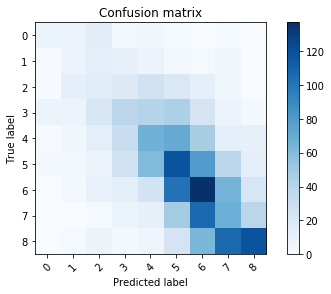

             precision    recall  f1-score   support

          0       0.35      0.17      0.23        42
          1       0.16      0.15      0.16        52
          2       0.15      0.14      0.15       111
          3       0.25      0.20      0.22       196
          4       0.26      0.26      0.26       258
          5       0.27      0.34      0.30       351
          6       0.29      0.36      0.32       377
          7       0.22      0.24      0.23       282
          8       0.58      0.36      0.44       330

avg / total       0.31      0.29      0.29      1999

      Business id      | actual stars | predicted stars
-----------------------|--------------|----------------
Apn5Q_b6Nz61Tq4XzPdf9A |         7    |          6
AjEbIBw6ZFfln7ePHha9PA |         4    |          3
O8S5hYJ1SMc8fA4QBtVujA |         7    |          5
bFzdJJ3wp3PZssNEsyU23g |         6    |          6
8USyCYqpScwiNEb58Bt6CA |         5    |          4


In [185]:
# Nearnest Neighbor

from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_Train, Y_Train)
knn_pred = knn.predict(X_Test)
knn_pred

#accuracy
score = metrics.accuracy_score(Y_Test, knn_pred)
print("Final accuracy: {}".format(score))

cm = metrics.confusion_matrix(Y_Test, knn_pred)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, stars)
plt.show()

print(metrics.classification_report(Y_Test, knn_pred))

predy=knn.predict(testx)
print("      Business id      | actual stars | predicted stars")
print("-----------------------|--------------|----------------")
for i in range(0,5):   
   print("%s |%10d    | %10d"
         %(b_id[i], testy[i], predy[i]))

## Multinomial Naive Bayes 

Final accuracy: 0.32716358179089544
[[ 12   1   0  15   1   5   1   0   7]
 [  9   1   0  28   2   7   1   0   4]
 [  5   1   1  36   9  36   6   3  14]
 [  6   0   0  52  17  72  21   2  26]
 [  1   0   0  36  11 124  37  13  36]
 [  0   0   0  19   6 118  98  17  93]
 [  0   0   0   2   1  79 166  34  95]
 [  0   0   0   1   0  18 114  21 128]
 [  0   0   0   1   0   4  38  15 272]]
Plotting confusion matrix


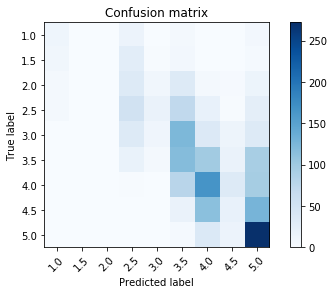

             precision    recall  f1-score   support

          0       0.36      0.29      0.32        42
          1       0.33      0.02      0.04        52
          2       1.00      0.01      0.02       111
          3       0.27      0.27      0.27       196
          4       0.23      0.04      0.07       258
          5       0.25      0.34      0.29       351
          6       0.34      0.44      0.39       377
          7       0.20      0.07      0.11       282
          8       0.40      0.82      0.54       330

avg / total       0.33      0.33      0.27      1999

      Business id      | actual stars | predicted stars
-------------------------------------------------------
Apn5Q_b6Nz61Tq4XzPdf9A |         7    |          8
AjEbIBw6ZFfln7ePHha9PA |         4    |          5
O8S5hYJ1SMc8fA4QBtVujA |         7    |          6
bFzdJJ3wp3PZssNEsyU23g |         6    |          6
8USyCYqpScwiNEb58Bt6CA |         5    |          6


In [178]:
#Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
clf = MultinomialNB()
clf.fit(X_Train, Y_Train)
mnb_pred = clf.predict(X_Test)

#accuracy
score = metrics.accuracy_score(Y_Test, mnb_pred)
print("Final accuracy: {}".format(score))

cm = metrics.confusion_matrix(Y_Test, mnb_pred)  
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, stars)
plt.show()

print(metrics.classification_report(Y_Test, mnb_pred))

predy=clf.predict(testx)
print("      Business id      | actual stars | predicted stars")
print("-----------------------|--------------|----------------")
for i in range(0,5):   
   print("%s |%10d    | %10d"
         %(b_id[i], testy[i], predy[i]))

In [179]:
np.arange(len(stars))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])